# Employee retention - Knowing when your employees will quit

---

## 1 - Introduction

Employees attrition can be very costly for companies as reports show that it costs employers [33% of an employee's annual salary to hire a replacement](https://www.benefitnews.com/news/avoidable-turnover-costing-employers-big) if that worker leaves. Moreover, it can jeopardize productivity, cause loss of knowledge and curb staff morale. 

Thus, providing solutions that could predict employee turnover could be greatly beneficial for companies. Furthermore, by using Survival Analysis and taking into account the time dimension, predicting when an employee will quit becomes possible.

---

## 2 - Dataset

### 2.1 - Description and Overview

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('employee_attrition').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (14999, 10).


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


### 2.2 - From categorical to numerical
There are several categorical features that need to be encoded into one-hot vectors:
* department
* salary 

In [2]:
# Creating the time and event columns
time_column = 'time_spend_company'
event_column = 'left'

# Creating one-hot vectors
category_columns = ['department', 'salary']
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)
dataset.head()

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

---

## 3 - Exploratory Data Analysis
As this tutorial is mainly designed to provide an example of how to use Pysurvival, we will not perform a thorough exploratory data analysis but we greatly encourage the reader to do so by taking a look at the **predictive maintenance tutorial** that provides a very detailed study.

Here, we will just check if the dataset contains Null values or duplicated rows, and have a look at feature correlations.

### 3.1 - Null values and duplicates
The first thing to do is checking if the `raw_dataset` contains Null values and has duplicated rows.

In [3]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 3008 duplicates


As it turns out the dataset doesn't have any Null values but had 3,008 duplicated rows.

### 3.2 - Correlations
Let's compute and visualize the correlation between the features

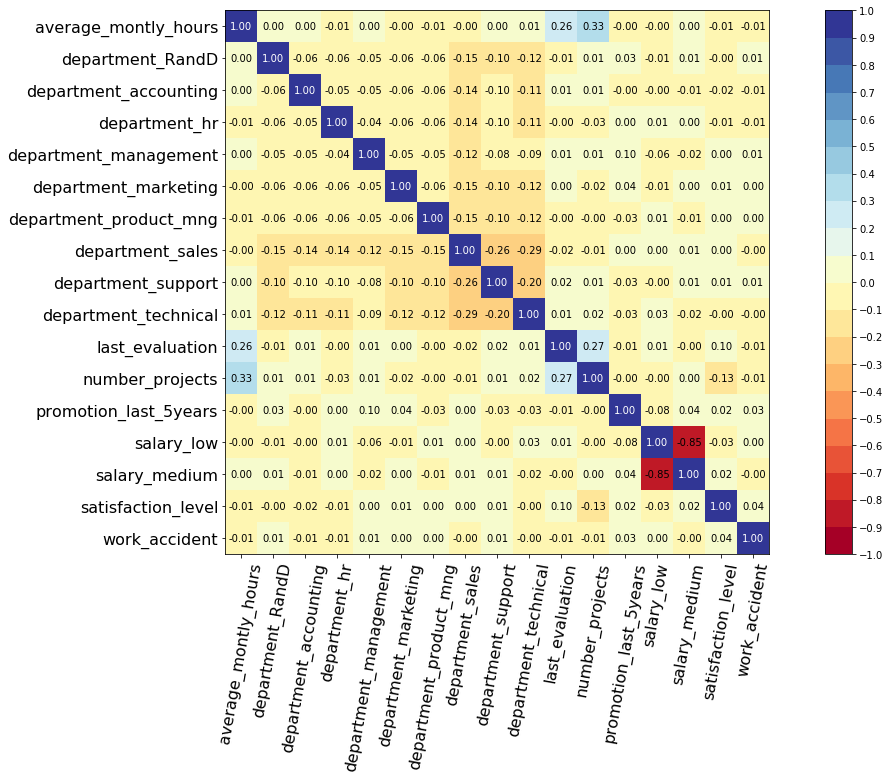

In [4]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(20,10), text_fontsize=10)

Based on the correlations chart, we should remove the feature `salary_low`

In [5]:
del dataset['salary_low']
features = np.setdiff1d( dataset.columns, [time_column, event_column] ).tolist()

---

## 4 - Modeling

### 4.1 - Building the model
As there are ~15,000 rows, we will first downsample the dataset to speed up computations, in case the computer that you are using cannot handle that size.
Then, so as to perform cross-validation later on and assess the performance of the model, we will split the dataset into training and testing sets.

In [6]:
# Downsampling the dataset to speed up computations
indexes_choices = np.random.choice(N, int(N*0.3), replace=False).tolist()

# Building training and testing sets #
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( indexes_choices, test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Let's now fit a Random Survival Forest model to the training set. 

*Note: The choice of the model and hyperparameters was obtained using grid-search selection, not displayed in this tutorial.*

In [7]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

# Fitting the model
rsf = RandomSurvivalForestModel(num_trees=100) 
rsf.fit(X_train, T_train, E_train, max_features='log2', 
        max_depth=2, min_node_size=5)

RandomSurvivalForestModel

---

## 5 - Cross Validation
In order to assess the model performance, we previously split the original dataset into training and testing sets, so that we can now compute its performance metrics on the testing set:

### 5.1 - C-index
The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [8]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(rsf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.80

C-index: 0.80


### 5.2 - Brier Score
The Brier score measures the average discrepancies between the status and the estimated probabilities at a given time. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

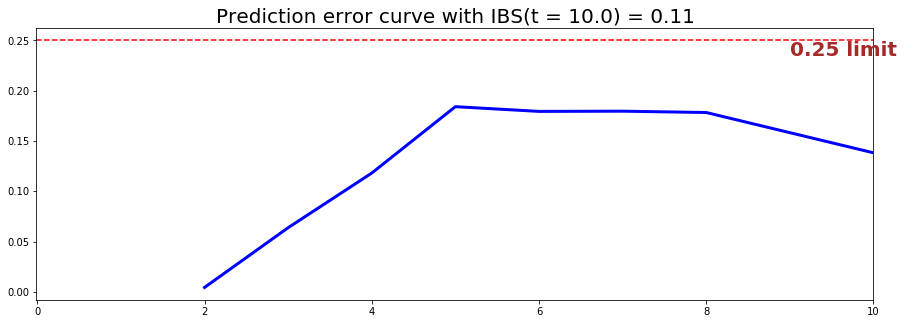

IBS: 0.11


In [9]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(rsf, X_test, T_test, E_test, t_max=12, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))#0.11

The IBS is equal to 0.11 on the entire model time axis. This indicates that the model will have good predictive abilities.

---

## 6 - Predictions
### 6.1 - Overall predictions
Now that we have built a model that seems to provide great performances, let's compare the time series of the actual and predicted number of employees who left the company, for each time t.

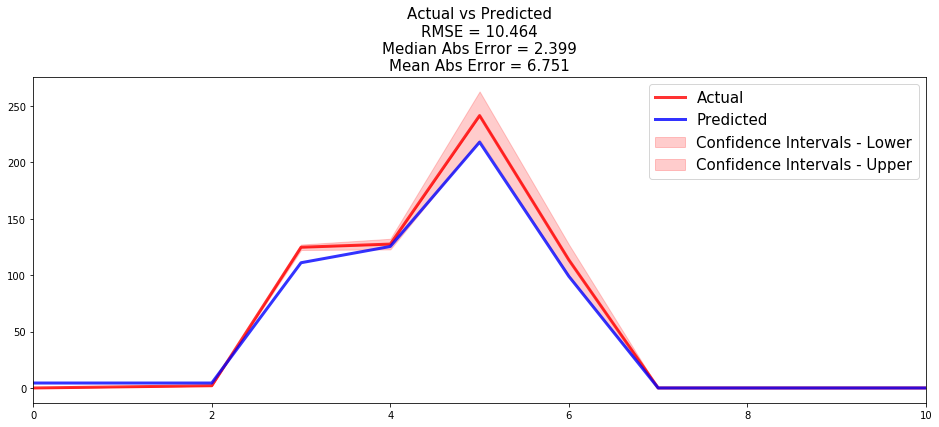

In [10]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(rsf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6), 
                            metrics = ['rmse', 'mean', 'median'])

### 6.2 - Individual predictions
Now that we know that we can provide reliable predictions for an entire cohort, let's compute the probability of remaining a customer for all times t.

First, we can construct the risk groups based on risk scores distribution. The helper function `create_risk_groups`, which can be found in `pysurvival.utils.display`, will help us do that:

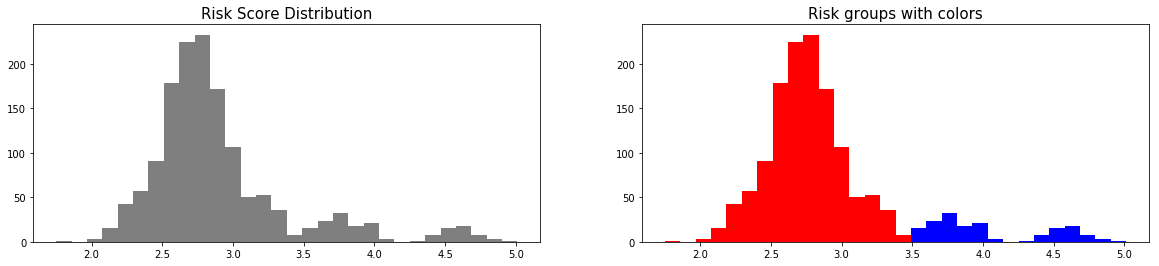

In [15]:
from pysurvival.utils.display import create_risk_groups
risk_groups = create_risk_groups(model=rsf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':3.4, 'color':'red'},
    high= {'lower_bound':3.4, 'upper_bound':10, 'color':'blue'}
    )

Here, it is possible to distinguish 2 main groups: **low** and **high** risk groups. Because the C-index is high, the model will be able to rank the survival times of a random unit of each group, such that $t_{high} \leq  t_{low}$.

Let's randomly select individual unit in each group and compare their likelihood to remain a customer. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

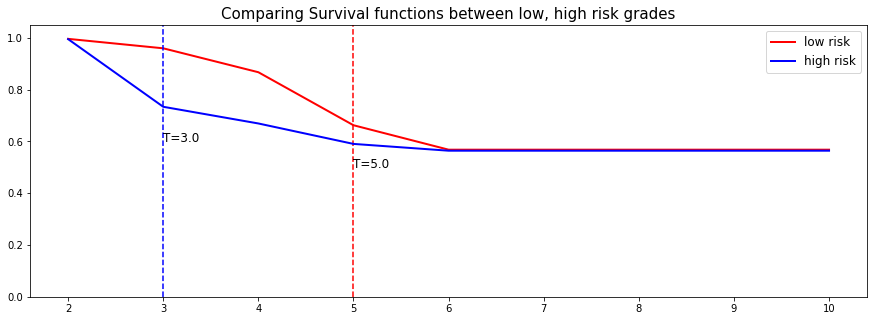

In [16]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = rsf.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(rsf.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)), 
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

---

## 7 - Conclusion
In conclusion, we can see that it is possible to predict the number of employees that will leave the company at different time points. Moreover, thanks to the feature importance of the RSF model, we can understand the reasons behind an employee decision to leave:

In [13]:
# Computing variables importance
rsf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,work_accident,4.274116,0.235809
1,number_projects,2.433926,0.134283
2,satisfaction_level,2.085549,0.115063
3,department_support,2.016703,0.111264
4,promotion_last_5years,1.702162,0.093911


In [14]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(rsf, '/Users/xxx/Desktop/employee_rsf.zip')

Saving the model to disk as /Users/xxx/Desktop/employee_rsf.zip


---

## References

* [2017 report by Employee Benefit News (EBN)](https://www.benefitnews.com/news/avoidable-turnover-costing-employers-big)
* [HR Dive - Study: Turnover costs employers $15,000 per worker](https://www.hrdive.com/news/study-turnover-costs-employers-15000-per-worker/449142/)
* [Employee Attrition dataset](https://github.com/ludovicbenistant/Management-Analytics/blob/master/HR/HR.csv)
* [Kaggle Competition - Employee Churn Prediction](https://www.kaggle.com/c/employee-churn-prediction)